In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from pomegranate import *
from scipy import stats

import config
import utility.df
import utility.iolib
import utility.plotlib
import model.performance

from utility.feature import Feature
from utility.feature import FeatureCM
from model.dataEngine import DataEngine
from model.featureConfig import FeatureConfig_G1
from model.featureConfig import FeatureConfig_G2
from model.featureConfig import FeatureConfig_G3
from model.mixtureModel import ModelParam
from model.mixtureModel import GroupConfig
from model.mixtureModel import MixtureModel

## Configuration and Data Loading

In [6]:
# Setup configuration
cfg = config.ResearchConfig_MonOnly
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=cfg.MONTHLY_ONLY)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

Complete loading data for subscription and lesson history!
By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

We also choose to remove 2525 annual subscribers. 

In summary, there are 3013/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 2672/2672 [00:04<00:00, 598.52it/s]


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


## Features Preparation

In [7]:
data_engine = DataEngine(df_subspt1, df_datesFrame, df_lesson1, df_incomp1, df_pupils, cfg)
data_engine.aggregate_features()

Construct feature object.
+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: math age.
+ Add feature: outcome.
Start binning stackDepth for complete lesson table.
Start binning stackDepth for incomplete lesson table.
+ Add feature: hardship.
+ Add feature: mark.
Aggregate data over customer months.


100%|██████████| 49/49 [00:34<00:00,  1.40it/s]


## Mixture Model Configuration

In [8]:
n_trials = 2

#np.random.seed(10)

modelParam_G1 = ModelParam(n_components=10, n_trials=n_trials, n_multi=3, baysian=True)
modelParam_G2 = ModelParam(n_components=3, n_trials=n_trials, n_multi=3, baysian=False)
modelParam_G3 = ModelParam(n_components=10, n_trials=n_trials, n_multi=1, baysian=True)

group_config = GroupConfig(data_engine, modelParam_G1, modelParam_G2, modelParam_G3)

## Mixture Model

In [13]:
mixture_model = MixtureModel(group_config)
mixture_model.fit()

# Select the best model
map_group_model = mixture_model.map_group_model_
map_group_model_best = mixture_model.select_bestMixtureModel('deviation')

# Plot
utility.plotlib.churn_distribution(mixture_model, ['G1-Inactive','G2-No Assess','G3-Others'])

Start fitting mixture model for G1.
Start fitting multivariate mixture models.
Trial NO. = 1/2
Trial NO. = 2/2
Start fitting mixture model for G2.
Improvement = 16.618063766375826
Weights = [0.43995614 0.34696506 0.21307881]
Start fitting multivariate mixture models.
Trial NO. = 1/2
Trial NO. = 2/2
Start fitting mixture model for G3.
Improvement = 2292.5256176472176
Weights = [0.32162237 0.16219931 0.49457239 0.02160592]
Improvement = 3862.232907450343
Weights = [0.15215305 0.01406388 0.26041479 0.57336829]
Improvement = 6813.077202115048
Weights = [0.09774079 0.06122022 0.06270979 0.7783292 ]
Improvement = 2185.9190623869217
Weights = [0.25646478 0.11438403 0.5670038  0.06214739]
Start fitting multivariate mixture models.
Trial NO. = 1/2
Trial NO. = 2/2


In [10]:
# Save object
#import pickle

#with open('mixture_model_2000.pkl', 'wb') as output:
#    pickle.dump(mixture_model, output, pickle.HIGHEST_PROTOCOL)

## Noise Test

In [11]:
def individual_churn_prob(map_group_model_best, list_group_name):

    churn_prob = np.array([])
    num_churn = 0.
    num_population = 0.
    for g in list_group_name:
        df_grouping = map_group_model_best[g][0]
        num_churn += (df_grouping['churn'] * df_grouping['count']).sum()
        num_population += df_grouping['count'].sum()
        for idx, row in df_grouping.iterrows():
            prob = row['churn']
            num = row['count']
            array = np.repeat(prob, num)
            churn_prob = np.hstack((churn_prob, array))
            
    return churn_prob, num_churn, num_population

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


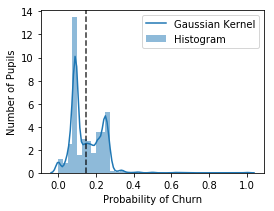

In [12]:
list_group_name = ['G1', 'G2', 'G3']
churn_prob, num_churn, num_population = individual_churn_prob(map_group_model_best, list_group_name)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
sns.distplot(churn_prob, bins=40, 
             hist_kws={'label':'Histogram', 'alpha':0.5}, 
             kde_kws={'label':'Gaussian Kernel'})
ax.axvline(x=num_churn/num_population, linestyle='--', color='k', alpha=.8)
ax.set_xlabel('Probability of Churn')
ax.set_ylabel('Number of Pupils')
#ax.text(num_churn/num_population*1.2, 8, 'Average churn')
ax.legend()

In [13]:
list_gs = [['G1'], ['G2'], ['G3']]
df1 = pd.DataFrame()
for list_g in list_gs:
    churn_prob, _, _ = individual_churn_prob(map_group_model_best, list_g)
    df = pd.DataFrame()
    df = df.assign(x=churn_prob)
    df['g'] = list_g[0] 
    df1 = pd.concat([df1, df], axis=0)

churn_prob_all, _, _ = individual_churn_prob(map_group_model_best, ['G1','G2','G3'])
df = pd.DataFrame()
df = df.assign(x=churn_prob_all)
df['g'] = 'All'
df1 = pd.concat([df1, df], axis=0)


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


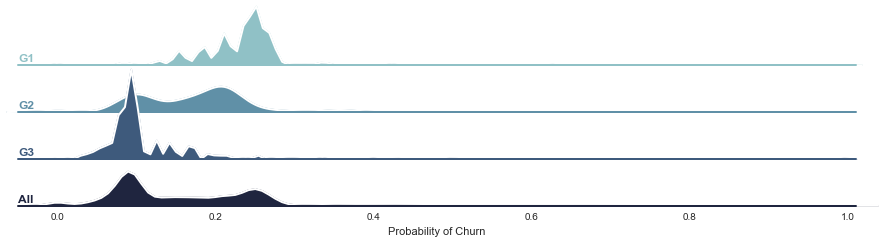

In [14]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(4, rot=-.25, light=.7)
g = sns.FacetGrid(df1, row="g", hue="g", aspect=15, size=.8, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2)
#g.map(sns.distplot, "x", bins=30, kde_kws={'color':'w', 'lw':1}, hist_kws={'alpha':1})
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.set_xlabels('Probability of Churn')
g.despine(bottom=True, left=True)

# Adjust the axis scope
axes = g.axes
axes[0,0].set_ylim(0,10)
axes[0,0].set_xlim([-0.05,1.01])

plt.tight_layout()
plt.savefig('')

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


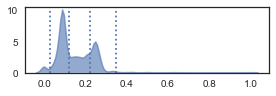

In [59]:
x = df1[df1['g']=='All']['x'].values
fig = plt.figure(figsize=(4,1.5))
ax = fig.add_subplot(111)
sns.kdeplot(x, clip_on=False, shade=True, alpha=.6, lw=1.5)
vs = [0.03, 0.12, 0.22, 0.35]
for v in vs:
    ax.axvline(v, linestyle=':')
plt.tight_layout()
plt.savefig('churnprob_all.png', dpi=500)
    
    
num_all = []
num_churn = []
ave_churn = []
for i in range(len(vs)+1):
    if i == 0:
        x1 = x[x<=vs[i]]
    elif i < len(vs):
        x1 = x[(x>vs[i-1])&(x<=vs[i])]
    else:
        x1 = x[x>vs[i-1]]
               
    num_all.append(len(x1))
    ave_churn.append(np.mean(x1))
    num_churn.append(num_all[i] * ave_churn[i])

num_all = np.array(num_all)
num_churn = np.array(num_churn)
ave_churn = np.array(ave_churn)

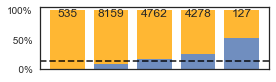

In [60]:
fig = plt.figure(figsize=(4,1.3))
ax = fig.add_subplot(111)
ax.bar(range(len(vs)+1), ave_churn, alpha=0.8)
rects = ax.bar(range(len(vs)+1), 1-ave_churn, bottom=ave_churn, alpha=0.8, color='orange')
for rect, value in zip(rects, num_all):
    ax.text(rect.get_x() + rect.get_width()/2., 0.9, 
                '{:d}'.format(value), ha='center')
#base_churn = expectations.sum()/expectations.shape[0]
ax.axhline(0.14, linestyle='--', color='k', alpha=0.8)
#ax.set_ylabel('Percentage')
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals]);
ax.set_xticks([])
plt.tight_layout()
plt.savefig('churncluster_all.png', dpi=500)

If the model is not able to distinguish users in terms of churn probability, then the worst model will result in predicting all users to have homogeneous distribution of churn probability. By central limit theorm, when the sample size goes large, the distrubution of churn probability converges to a normal distribution. Hence, we'll do the hypothesis testing here:

$H_0$ = The distribution of churn probability follows normal distribution

In [17]:
k2, p = stats.normaltest(df1[df1['g']=='All']['x'])
p

0.0

## Importance Measurement for Features

The goal is to study the importance of each feature in clustering.

We are more interested in features with predictive power in distinguishing highest-churn cluster and lowest-churn cluster.

In [18]:
threshold_risk = 0.5
threshold_safe = 0.05

group_name = 'G3'

df_whizz = mixture_model.group_config_.df_whizz_G3_
feature_config = mixture_model.group_config_.ftrConfig_G3_

df_grouping = map_group_model_best[group_name][0]
map_var_ftr = mixture_model.map_group_model_[group_name][4]
list_var_name = list(map_var_ftr.keys())

def find_mostImpComp(tag, mask, df_grouping, list_var_name):
    df_grouping_cond = df_grouping[mask]

    df_imp = pd.DataFrame(columns=['var', 'compId_'+tag, 'score_'+tag])
    for i, var_name in enumerate(list_var_name):
        val_count_cond = df_grouping_cond[var_name].value_counts()
        val_count = df_grouping[var_name].value_counts()
        val_density = val_count/val_count.sum()
        val_count_cond = df_grouping_cond[var_name].value_counts()
        val_density_cond = val_count_cond/val_count_cond.sum()

        #cond_prob = val_count_cond / val_count
        score = val_density_cond / val_density
        imp_score = score.max()
        imp_compId = score.idxmax()
    
        df_imp.loc[i] = [var_name, imp_compId, imp_score]
    
    df_imp.set_index(['var'], inplace=True)
        
    return df_imp

tag_risk = 'risk'
tag_safe = 'safe'
mask_risk = df_grouping['churn']>threshold_risk
mask_safe = df_grouping['churn']<threshold_safe
df_imp_risk = find_mostImpComp(tag_risk, mask_risk, df_grouping, list_var_name)
df_imp_safe = find_mostImpComp(tag_safe, mask_safe, df_grouping, list_var_name)

In [20]:
def component_mixtureModel(feature_name, feature_data, mixture_model, list_labels, list_colors, list_legends):
    x = feature_data
    #xbin = np.arange(x.min()-(x.max()-x.min())/50., x.max()*1.1, 
    #                 (x.max()-x.min())/hist_bin)
    xs = np.arange(x.min(), x.max(), 
                   (x.max()-x.min())/100.)
    prob = mixture_model.probability(xs)

    plt.figure(figsize=(5, 3))
    plt.subplot(111)
    plt.title(feature_name, fontsize=12)
    #N, bins, patches = plt.hist(x, bins=xbin, alpha=0.6, density=True)
    
    #n_patches = len(patches)
    #len_patch = (x.max() - x.min())*1. / n_patches
    labels = mixture_model.predict(x)
    for label, color, legend in zip(list_labels, list_colors, list_legends):
        x1 = x[labels==label]
        #left = int(np.floor((x1.min()-x.min()) / len_patch)-1)
        #right = int(np.ceil((x1.max()-x.min()) / len_patch)-1)
        #for i in range(left, right+1):
        #    patches[i].set_facecolor(color)
        shade_region = (xs<=x1.max()) & (xs>=x1.min())
        plt.fill_between(xs[shade_region], prob[shade_region], color=color, alpha=.8, label=legend)
          
    plt.plot(xs, prob, color='w')
    plt.fill_between(xs, prob, alpha=0.3)
    
    plt.ylabel("Density", fontsize=12); plt.yticks(fontsize=12)
    plt.xlabel("Value", fontsize=12); plt.yticks(fontsize=12)
    plt.yscale('log')
    
    plt.legend(loc='upper right')

    plt.tight_layout()

Improvement = 2292.897369428625
Weights = [0.32162481 0.16204382 0.49465023 0.02168114]
Improvement = 3862.232907450343
Weights = [0.15215305 0.01406388 0.26041479 0.57336829]
Improvement = 6813.077202115048
Weights = [0.09774079 0.06122022 0.06270979 0.7783292 ]
Improvement = 2185.9190623869217
Weights = [0.25646478 0.11438403 0.5670038  0.06214739]


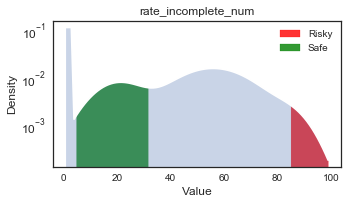

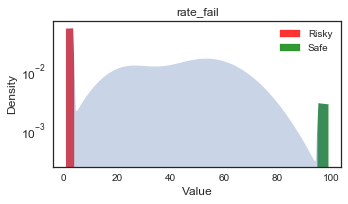

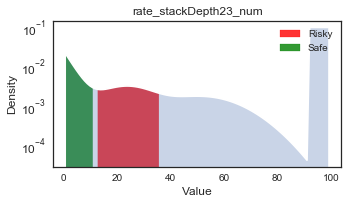

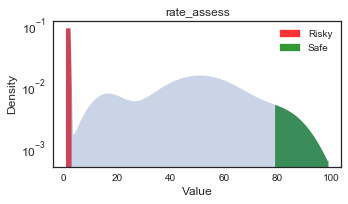

In [21]:
df_imp = pd.concat([df_imp_risk, df_imp_safe], axis=1)
list_colors = ['r', 'g']
list_legends=['Risky', 'Safe']
for var_name in list_var_name:
    list_labels = []
    df = df_imp[df_imp.index.values==var_name]
    list_labels.append(df['compId_risk'].values[0])   
    list_labels.append(df['compId_safe'].values[0])
    
    feature_name = map_var_ftr[var_name]
    _, x, _ = mixture_model.fit_independentComponent(df_whizz, feature_config, feature_name)
    gmm = mixture_model.map_group_model_best_['G3'][3][var_name]
    component_mixtureModel(feature_name, x, gmm, list_labels, list_colors, list_legends)
    plt.tight_layout()
    plt.savefig('ftrImp'+feature_name+'.png', dpi=500)

## Aggregate clustering - over all G1, G2, G3

In [70]:
# Get dataframe with columns = ['pupilId', 'cmonth', 'churnProb']

df_churnProb = pd.DataFrame()

list_group_name = ['G1', 'G2', 'G3']
for group_name in list_group_name:
    df_grouping = mixture_model.map_group_model_best_[group_name][0]
    map_group_pupilId = mixture_model.map_group_model_best_[group_name][1]
    map_group_cmonth = mixture_model.map_group_model_best_[group_name][2]
    
    df_churnProb_g = pd.DataFrame()

    for idx, row in df_grouping.iterrows():
        prob = row['churn']
        num = row['count']
        groupId = row['groupId']
    
        # Array of churn probability
        prob_array = np.repeat(prob, num)
        # Array of pupil ID
        pupilId_array = map_group_pupilId[groupId]
        # Array of customer month
        cmonth_array = map_group_cmonth[groupId]
    
        data = {'pupilId': pupilId_array,
                'cmonth': cmonth_array,
                'churnProb': prob_array}
        df = pd.DataFrame(data)
        df_churnProb = pd.concat([df_churnProb, df], axis=0)
    
    df_churnProb = pd.concat([df_churnProb, df_churnProb_g], axis=0)

df_churnProb.sort_values(by=['churnProb'], ascending=False, inplace=True)
df_churnProb.reset_index(inplace=True)
df_churnProb.drop(columns=['index'], inplace=True)

In [94]:
state_anchors = [0.03, 0.22, 0.35]
n_state = len(state_anchors)+1

for i in range(n_state):
    if i==0:
        lower = 0.0
        upper = state_anchors[i]
    elif i==n_state-1:
        lower = state_anchors[i-1]
        upper = 1.0
    else:
        lower = state_anchors[i-1]
        upper = state_anchors[i]
    
    mask = (df_churnProb['churnProb']>=lower) & (df_churnProb['churnProb']<=upper)
    df_churnProb.loc[mask, 'clusterId'] = 'S'+str(i+1)

In [95]:
clusterId_list = df_churnProb['clusterId'].unique().tolist()
clusterId_list.append('Cancel')

In [96]:
def compute_transitNumber(df_cluter_details, cluster_init, cluster_next):
    c_init = cluster_init
    c_next = cluster_next
    max_cmonth = df_cluter_details['cmonth'].max()
    
    if not cluster_next=='Cancel': 
        num_pupils_transit = 0
        for t in range(1, max_cmonth):
            mask_init_t = (df_cluter_details['clusterId']==c_init) & (df_cluter_details['cmonth']==t)
            mask_next_tPlus1 = (df_cluter_details['clusterId']==c_next) & (df_cluter_details['cmonth']==t+1)
            pupils_init_t = df_cluter_details[mask_init_t]['pupilId'].values
            pupils_next_tPlus1 = df_cluter_details[mask_next_tPlus1]['pupilId'].values
            pupils_transit_t = np.intersect1d(pupils_init_t, pupils_next_tPlus1)
            num_pupils_transit += pupils_transit_t.shape[0]
        return num_pupils_transit
    
    num_pupils_vanish = 0
    for t in range(1, max_cmonth):
        mask_init_t = (df_cluter_details['clusterId']==c_init) & (df_cluter_details['cmonth']==t)
        pupils_init_t = df_cluter_details[mask_init_t]['pupilId'].values
        pupils_tPlus1 = df_cluter_details[df_cluter_details['cmonth']==t+1]['pupilId'].values
        pupils_notVanish = np.intersect1d(pupils_init_t, pupils_tPlus1)
        pupils_vanish = np.setdiff1d(pupils_init_t, pupils_notVanish)
        num_pupils_vanish += pupils_vanish.shape[0]
        
    return num_pupils_vanish

In [109]:
df_transition_prob = pd.DataFrame()
n_cluster = len(clusterId_list)

warnings.filterwarnings('ignore')
for c_init in tqdm(clusterId_list):
    num_transit_list = []
    for c_next in clusterId_list:
        num_transit = compute_transitNumber(df_churnProb, c_init, c_next)
        num_transit_list.append(num_transit)

    num_transit_list = np.array(num_transit_list)
    if c_init == 'Cancel':
        prob_transit_list = num_transit_list / num_transit_list.sum()
    else:
        prob_transit_list = (num_transit_list + 1) / (num_transit_list.sum() + n_cluster)
    
    df = pd.DataFrame()
    df = df.assign(prob=prob_transit_list,
                   count=num_transit_list,
                   cfrom=c_init,
                   cto=clusterId_list)
    
    df_transition_prob = pd.concat([df_transition_prob, df], axis=0)

df_transition_prob.fillna(0., inplace=True)
df_transition_prob.loc[(df_transition_prob['cfrom']=='Cancel') & (df_transition_prob['cto']=='Cancel'), 'prob'] = 1.

100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


In [110]:
#df_transition_prob.loc[df_transition_prob['prob']<0.05, 'prob'] = 0.0
df_transition_prob.reset_index(inplace=True)

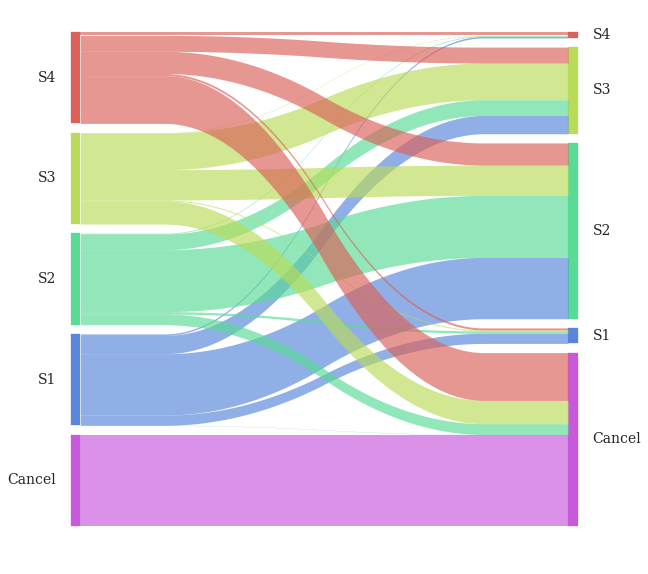

In [115]:
import utility.sankey as sankey

leftLabels = ['Cancel', 'S1', 'S2', 'S3', 'S4']
rightLabels = ['Cancel', 'S1', 'S2', 'S3', 'S4']
sankey.sankey(df_transition_prob['cfrom'], df_transition_prob['cto'], leftWeight=df_transition_prob['prob'], 
              leftLabels=leftLabels, rightLabels=rightLabels, aspect=20, rightColor=False)
plt.gcf().set_size_inches(10,10)
plt.savefig('Transition.png',bbox_inches='tight',dpi=500)

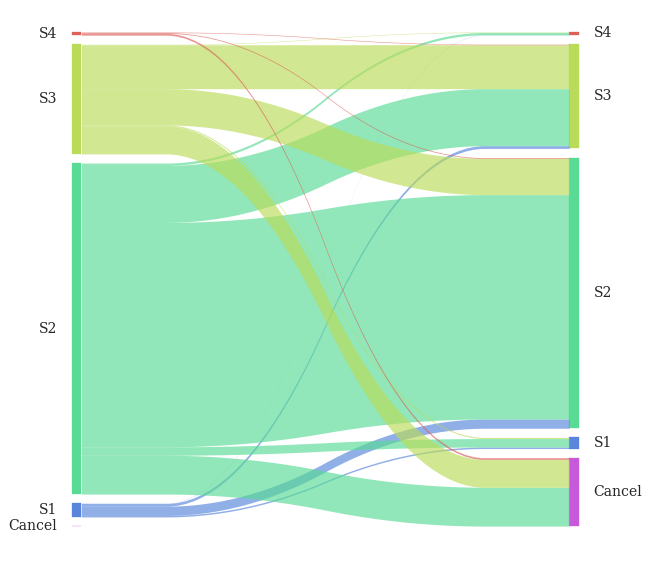

In [117]:
leftLabels = ['Cancel', 'S1', 'S2', 'S3', 'S4']
rightLabels = ['Cancel', 'S1', 'S2', 'S3', 'S4']
sankey.sankey(df_transition_prob['cfrom'], df_transition_prob['cto'], leftWeight=df_transition_prob['count'], 
              leftLabels=leftLabels, rightLabels=rightLabels, aspect=20, rightColor=False)
plt.gcf().set_size_inches(10,10)
plt.savefig('Transition.png',bbox_inches='tight',dpi=500)

## Aggregate clusterings - within G1, G2, G3

In [78]:
# Config of aggregation
agg_anchors_G1 = [0, 1, 90, 100]
agg_anchors_G2 = [0, 10, 90, 100]
agg_anchors_G3 = [0, 1, 5, 90, 100]

map_cluster_anchors = {'G1': agg_anchors_G1,
                       'G2': agg_anchors_G2,
                       'G3': agg_anchors_G3}

mixture_model.cluster(map_cluster_anchors)

df_cluster = mixture_model.df_cluster_
df_cluster_details = mixture_model.df_cluster_details_

## Transitional Analysis

In [79]:
clusterId_list = df_cluster_details['clusterId'].unique().tolist()
clusterId_list.append('Cancel')

In [80]:
df_transition_prob = pd.DataFrame()

warnings.filterwarnings('ignore')
for c_init in tqdm(clusterId_list):
    num_transit_list = []
    for c_next in clusterId_list:
        num_transit = compute_transitNumber(df_cluster_details, c_init, c_next)
        num_transit_list.append(num_transit)

    num_transit_list = np.array(num_transit_list)
    prob_transit_list = num_transit_list / num_transit_list.sum()
    
    df = pd.DataFrame()
    df = df.assign(prob=prob_transit_list,
                   cfrom=c_init,
                   cto=clusterId_list)
    
    df_transition_prob = pd.concat([df_transition_prob, df], axis=0)

df_transition_prob.fillna(0., inplace=True)
df_transition_prob.loc[(df_transition_prob['cfrom']=='Cancel') & (df_transition_prob['cto']=='Cancel'), 'prob'] = 1.

100%|██████████| 11/11 [00:27<00:00,  2.50s/it]


In [81]:
df_transition_prob.loc[df_transition_prob['prob']<0.05, 'prob'] = 0.0
df_transition_prob.reset_index(inplace=True)

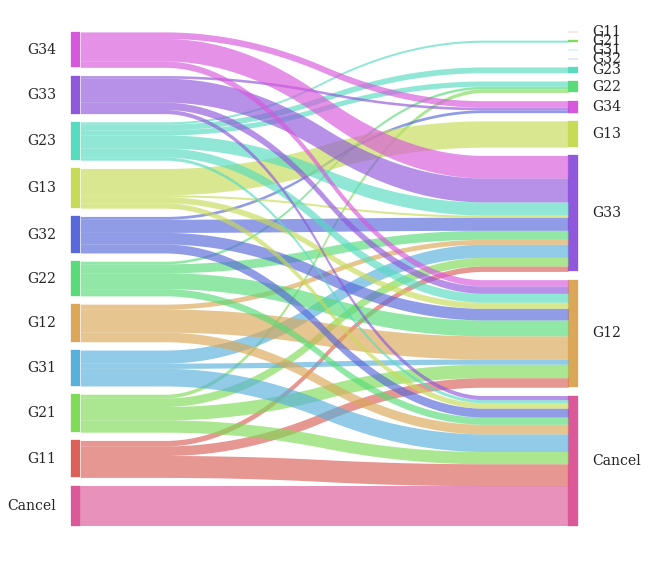

In [82]:
import utility.sankey as sankey

leftLabels = ['Cancel', 'G11', 'G21', 'G31', 'G12', 'G22',  'G32', 'G13', 'G23', 'G33', 'G34']
rightLabels = ['Cancel', 'G12', 'G33', 'G13', 'G34', 'G22', 'G23', 'G32', 'G31', 'G21', 'G11']
sankey.sankey(df_transition_prob['cfrom'], df_transition_prob['cto'], leftWeight=df_transition_prob['prob'], 
              leftLabels=leftLabels, rightLabels=rightLabels, aspect=20, rightColor=False)
plt.gcf().set_size_inches(10,10)
plt.savefig('Transition.png',bbox_inches='tight',dpi=500)

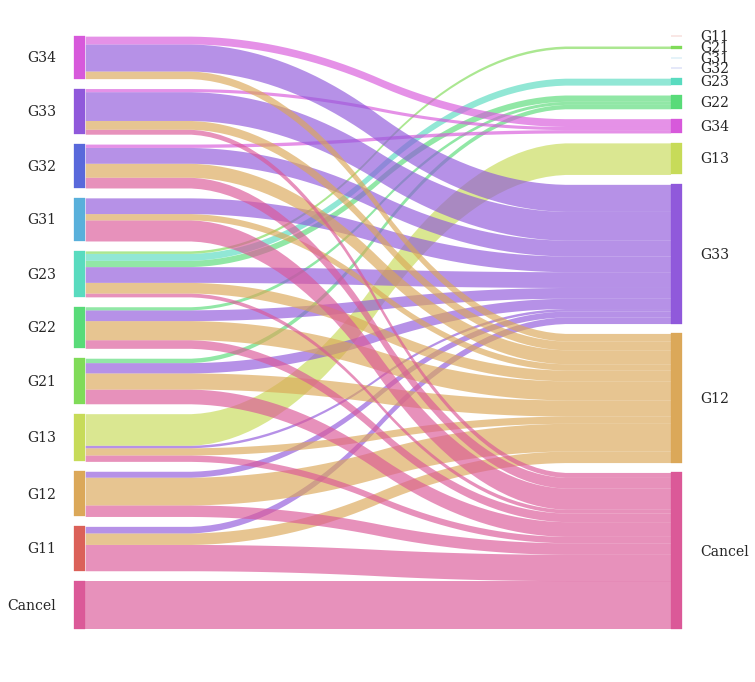

In [83]:
leftLabels = ['Cancel', 'G11', 'G12', 'G13', 'G21', 'G22',  'G23', 'G31', 'G32', 'G33', 'G34']
rightLabels = ['Cancel', 'G12', 'G33', 'G13', 'G34', 'G22', 'G23', 'G32', 'G31', 'G21', 'G11']
sankey.sankey(df_transition_prob['cfrom'], df_transition_prob['cto'], leftWeight=df_transition_prob['prob'], 
              leftLabels=leftLabels, rightLabels=rightLabels, aspect=20, rightColor=True)
plt.gcf().set_size_inches(12,12)

## Source code - df_cluster, df_cluster_details

In [46]:
list_agg_anchors = [agg_anchors_G1, agg_anchors_G2, agg_anchors_G3]

list_df_cluster = []
list_map_cluster_pupilId = []
list_map_cluster_cmonth = []

for g in range(3):
    group_name = list_group_name[g]
    df_grouping = list_df_grouping[g]
    y = list_y[g]
    agg_anchors = list_agg_anchors[g]
    map_group_pupilId = map_group_model_best[group_name][1]
    map_group_cmonth = map_group_model_best[group_name][2]

    num_agg = len(agg_anchors) - 1
    agg_churn = []
    agg_count = []
    cluster_Id = []
    map_cluster_pupilId = {}
    map_cluster_cmonth = {}
    
    l = np.arange(0, len(y))+1
    for i in range(len(agg_anchors)):
        if i==0:
            continue
        else:
            lower = np.percentile(l, agg_anchors[i-1])
            upper = np.percentile(l, agg_anchors[i])
    
        # Define sub-dataframe
        if i==len(agg_anchors)-1:
            mask = (df_grouping['cumcount']>=lower) & (df_grouping['cumcount']<=upper)
        else:
            mask = (df_grouping['cumcount']>=lower) & (df_grouping['cumcount']<upper)
        df_grouping.loc[mask, 'agg'] = i
        df = df_grouping[mask]
    
        # Get information of pupilId and customer_month
        groupId = df['groupId'].values
        pupilId = np.hstack([map_group_pupilId[key] for key in groupId])
        cmonth = np.hstack([map_group_cmonth[key] for key in groupId])
    
        temp = df['churn'] * df['count']
        num_churn = temp.sum()
        agg_count.append(df['count'].sum())
        agg_churn.append(num_churn*1./agg_count[i-1])
        cluster_Id.append(group_name+str(i))
        map_cluster_pupilId[group_name+str(i)] = pupilId
        map_cluster_cmonth[group_name+str(i)] = cmonth

    data = {'count': agg_count,
            'churn': agg_churn,
            'clusterId': cluster_Id}

    df_grouping_agg = pd.DataFrame(data)
    df_grouping_agg['cumcount'] = df_grouping_agg['count'].cumsum()
    
    list_df_cluster.append(df_grouping_agg)
    list_map_cluster_pupilId.append(map_cluster_pupilId)
    list_map_cluster_cmonth.append(map_cluster_cmonth)

In [47]:
df_cluster = pd.DataFrame()
map_cluster_pupilId = {}
map_cluster_cmonth = {}
for i in range(3):
    df_cluster = pd.concat([df_cluster, list_df_cluster[i]], axis=0)
    map_cluster_pupilId.update(list_map_cluster_pupilId[i])
    map_cluster_cmonth.update(list_map_cluster_cmonth[i])

In [48]:
df_cluter_details = pd.DataFrame()
for key in map_cluster_pupilId.keys():
    df = pd.DataFrame()
    df = df.assign(pupilId = map_cluster_pupilId[key],
                   cmonth = map_cluster_cmonth[key])
    df['clusterId'] = key
    df_cluter_details = pd.concat([df_cluter_details, df], axis=0)

## Source Code - Groups

In [4]:
df_whizz1 = data_engine.df_whizz_

mask_churn = df_whizz1.churn==1
mask_inactive = df_whizz1.active==0
mask_noassess = (df_whizz1.assess==0) & (df_whizz1.active==1)
mask_fine = ~mask_inactive & ~mask_noassess

print('Churn rate for inactive subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_inactive&mask_churn].shape[0]/df_whizz1[mask_inactive].shape[0]*100))
print('Churn rate for active subscribers = {:.2f}%.'.\
      format(df_whizz1[~mask_inactive&mask_churn].shape[0]/df_whizz1[~mask_inactive].shape[0]*100))

print('Churn rate for subscribers having no assessment = {:.2f}%.'.\
      format(df_whizz1[mask_noassess&mask_churn].shape[0]/\
             df_whizz1[mask_noassess].shape[0]*100))
print('Churn rate for subscribers having assessment = {:.2f}%.'.\
      format(df_whizz1[~mask_noassess&mask_churn&~mask_inactive].shape[0]/\
             df_whizz1[~mask_noassess&~mask_inactive].shape[0]*100))

print('Churn rate for good-quality subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_fine&mask_churn].shape[0]/\
             df_whizz1[mask_fine].shape[0]*100))
print('Churn rate for not good-quality subscribers = {:.2f}%.'.\
      format(df_whizz1[~mask_fine&mask_churn].shape[0]/\
             df_whizz1[~mask_fine].shape[0]*100))
print('Churn rate for all subscribers = {:.2f}%.'.\
      format(df_whizz1[mask_churn].shape[0]/\
             df_whizz1.shape[0]*100))

df_whizz_G1 = df_whizz1[mask_inactive]
df_whizz_G2 = df_whizz1[mask_noassess]
df_whizz_G3 = df_whizz1[mask_fine]

ftrConfig_G1 = FeatureConfig_G1()
ftrConfig_G2 = FeatureConfig_G2()
ftrConfig_G3 = FeatureConfig_G3()

Churn rate for inactive subscribers = 22.99%.
Churn rate for active subscribers = 10.46%.
Churn rate for subscribers having no assessment = 16.94%.
Churn rate for subscribers having assessment = 10.21%.
Churn rate for good-quality subscribers = 10.21%.
Churn rate for not good-quality subscribers = 22.61%.
Churn rate for all subscribers = 14.96%.


In [6]:
def fit_independentComponent(df_whizz, feature_config, feature_name, plot=0, hist_bin=35):
    '''Fit mixed distributions for features defined as independent component.
    
    Parameters
    ----------
    df_whizz: pandas.DataFrame
        Data frame storing feature and target data for specific group.
    
    feature_config: FeatureConfig object
        Feature configuration for specific group.
    
    feature_name: string
        Feature name.
    
    plot: int
        If plot=0, then no plot will be shown;
        If plot=1, then the density plot of fitted mixture model along with histogram will be shown;
        If plot>1, then the Gaussian KDE and histogram plots of raw and transformed data will be shown.
    
    hist_bin: int
        The number of bins in the density and histogram plot (when plot=1).
    
    Returns
    -------
    gmm: GeneralMixtureModel object
        The trained GeneralMixtureModel object which can be used to predict the labels and probabilities.
    
    x: array_like, shape=(n_sample, 1)
        Feature data.
    '''
    from scipy import stats
    from sklearn.preprocessing import MinMaxScaler
    
    ftr_config = eval('feature_config.'+feature_name)

    if plot>1:
        utility.plotlib.compare_transformed_singleValueRemoved(df_whizz, feature_name, 'min')
        
    # Define the data to be fitted
    x_raw = df_whizz[feature_name].values
    # Linear transformation
    x = x_raw * ftr_config.multiplierPre
    x += ftr_config.shiftPre
    # Box-cox transformation
    if ftr_config.bcTransform:
        xt, bc_param = stats.boxcox(x)
        x = xt
    x = x.reshape(-1,1)
    # Standardisation
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    x *= ftr_config.multiplierPost
    x += ftr_config.shiftPost

    # Define the list of distributions to be mixed
    distribution_list = ftr_config.distributionList

    gmm = GeneralMixtureModel(distribution_list)
    print('Improvement = {}'.format(gmm.fit(x, verbose=False)))
    print('Weights = {}'.format(np.exp(gmm.weights)))

    if plot==1:
        utility.plotlib.density_mixtureModel(feature_name, x, gmm, hist_bin=hist_bin)
    
    return gmm, x

In [7]:
def getData_multivariateComponent(df_whizz, feature_config):
    '''Prepare the feature and target data for multivariate compoments.
    
    Parameters
    ----------
    df_whizz: pandas.DataFrame
        Data frame storing feature and target data for specific group.
        
    feature_config: FeatureConfig object
        Feature configuration for specific group.
    
    Returns
    -------
    X: array_like, shape=(n_sample, n_features)
        Feature data.
        
    y: array_like, shape=(n_sample, 1)
        Target data (1 for churn, 0 otherwise).
    '''
    
    from scipy import stats
    from sklearn.preprocessing import MinMaxScaler
    
    ftr_list_multivariate = feature_config.ftr_list_multivariate

    # Linear transformation
    X = np.array(df_whizz[ftr_list_multivariate]+feature_config.multivariate_shift)
    # Box-Cox transformation
    Xt = X
    for i in range(0, X.shape[1]):
        xt, _ = stats.boxcox(X[:,i])
        Xt[:, i] = xt
    # Standardisation
    Xt_scaled = MinMaxScaler().fit(Xt).transform(Xt)

    y = df_whizz.churn.values
    
    return Xt_scaled, y

def construct_df_grouping(group, group_name, df_whizz):
    # Identify unique groups/labels and frequency
    label = np.array(group).transpose()
    unq_rows, count = np.unique(label, axis=0, return_counts=True)
    map_group_count = {tuple(i):j for i,j in zip(unq_rows,count)}

    # Compute churn rate within each group
    map_group_churn = {}
    map_group_pupilId = {}
    map_group_cmonth = {}
    pupilId = df_whizz.reset_index()['pupilId'].values
    customer_month = df_whizz.reset_index()['customer_month'].values
    
    for k in range(0, len(unq_rows)):
        indices = [i for i, x in enumerate(label.tolist()) if x==unq_rows[k].tolist()]
        l = y[indices]
        map_group_churn[tuple(unq_rows[k])] = l.sum()*1. / len(l)
        map_group_pupilId[k] = pupilId[indices]
        map_group_cmonth[k] = customer_month[indices]
        
    # Construct the grouping data frame
    df_grouping = pd.DataFrame(unq_rows, columns=group_name)
    df_grouping['groupId'] = range(len(df_grouping))
    df_grouping = df_grouping.assign(count=count,
                                     churn=list(map_group_churn.values()))
    df_grouping.sort_values(by='churn', ascending=False, inplace=True)
    df_grouping['cumcount'] = df_grouping['count'].cumsum()
    
    
    return df_grouping, map_group_pupilId, map_group_cmonth

def compute_groupingScore(df_grouping_list, expectation, criterion='deviation'):
    score_list = []
    y = expectation
    for df_grouping in df_grouping_list:
        base_churn = y.sum()*1. / len(y)
        group_churn = df_grouping['churn'].values
        group_count = df_grouping['count'].values
        if criterion=='deviation':
            score = np.sum(abs(base_churn-group_churn)* group_count)
        elif criterion=='variance':
            score = np.sum((base_churn-group_churn)**2 * group_count**2)
        elif criterion=='max_number':
            score = max((group_churn-base_churn)* group_count)
        elif criterion=='min_number':
            score = -min((group_churn-base_churn)* group_count)
        score_list.append(score)
    
    return score_list

## Source Code - Fitting Mixture Model

In [236]:
ftrConfig = ftrConfig_G1
df_whizz = df_whizz_G1

n_components = 10
n_trials = 2
n_multi = 2

baysian = True

#############
def fit_mixtureModel(df_whizz, ftrConfig, n_components, n_trials, n_multi, baysian):
    from sklearn import mixture
    X, y = getData_multivariateComponent(df_whizz, ftrConfig)

    ftr_list_multivariate = ftrConfig.ftr_list_multivariate
    ftr_list_independent = ftrConfig.ftr_list_independent

    # Mixture model for independent components
    group_ic = []
    group_ic_name = []
    n_var_indep = len(ftr_list_independent)
    for i_var in range(n_var_indep):
        ftr_str = ftr_list_independent[i_var]
        gmm, x = fit_independentComponent(df_whizz, ftrConfig, ftr_str, plot=1, hist_bin=35)
        l = gmm.predict(x)
        group_ic.append(l)
        group_ic_name.append('indep'+str(i_var))
    
    # Mixture model for multivariate components
    n_features = len(ftr_list_multivariate)
    df_grouping_list = []
    map_group_pupilId_list = []
    map_group_cmonth_list = []
    print('Start fitting multivariate mixture models.')
    for trial in range(0, n_trials):
        print('Trial NO. = {}/{}'.format(trial+1, n_trials))
    
        group = group_ic[:]
        group_name = group_ic_name[:]
    
        for i_multi in range(0, n_multi):
            if baysian:
                dpgmm = mixture.BayesianGaussianMixture(
                    n_components=n_components,
                    covariance_type='full',
                    covariance_prior=1e0 * np.eye(n_features),
                    weight_concentration_prior_type='dirichlet_process',
                    init_params="random", tol=1e-6, max_iter=10000, n_init=1, 
                    verbose=0, verbose_interval=100).fit(X)
                l = dpgmm.predict(X)
            else:
                gmm = mixture.GaussianMixture(
                    n_components=n_components, 
                    covariance_type='full',
                    init_params='random',
                    verbose=0, verbose_interval=100,
                    n_init=1, tol=1e-6, max_iter=1000).fit(X)
                l = gmm.predict(X)
        
            group.append(l)
            group_name.append('multi'+str(i_multi))
    
        df_grouping, map_group_pupilId, map_group_cmonth = construct_df_grouping(group, group_name, df_whizz)
        df_grouping_list.append(df_grouping)
        map_group_pupilId_list.append(map_group_pupilId)
        map_group_cmonth_list.append(map_group_cmonth)
        
    return  df_grouping_list, map_group_pupilId_list, map_group_cmonth_list

def select_bestMixtureModel(df_grouping_list, map_group_pupilId_list, map_group_cmonth_list, criterion='deviation'):

    # Evaluate different groupings and select the best
    score_list = compute_groupingScore(df_grouping_list, y)
    idx_maxScore = np.argmax(score_list)
    df_grouping = df_grouping_list[idx_maxScore]
    map_group_pupilId = map_group_pupilId_list[idx_maxScore]
    map_group_cmonth = map_group_cmonth_list[idx_maxScore]
    
    return df_grouping, map_group_pupilId, map_group_cmonth

In [237]:
df_grouping_list, map_group_pupilId_list, map_group_cmonth_list = fit_mixtureModel(
    df_whizz, ftrConfig, n_components, n_trials, n_multi, baysian)
df_grouping, map_group_pupilId, map_group_cmonth = select_bestMixtureModel(
    df_grouping_list, map_group_pupilId_list, map_group_cmonth_list, criterion='deviation')

Start fitting multivariate mixture models.
Trial NO. = 1/2
Trial NO. = 2/2
